In [ ]:
!nvidia-smi

Tue Dec 28 12:06:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

import random
import math

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip -qq '/content/drive/My Drive/MI Project/DDS_fullData/train.zip'
!unzip -qq '/content/drive/My Drive/MI Project/DDS_fullData/v.zip'
!unzip -qq '/content/drive/My Drive/MI Project/DDS_fullData/test.zip'

In [ ]:
import random
def special_function(img):
    '''
    The default:
    - adjust_brightness: contrast range is 0.05 to 0.25
    - 
    '''

    brightness_factor = random.uniform(0.05, 0.25)
    im = tf.image.adjust_brightness(img, brightness_factor)

    #contrast_factor = random.uniform(0.05, 0.95)
    #im = tf.image.adjust_contrast(im, contrast_factor)
    
    saturation_factor = random.uniform(0.25, 3)
    im = tf.image.adjust_saturation(im, saturation_factor, name=None)

    #delta = random.uniform(0.1, 0.19)
    #im = tf.image.adjust_hue(im, delta, name=None)
    return im

In [ ]:
BatchSize = 16

#channel_shift_range=0.14, rotation_range=15, shear_range=5, zoom_range=0.1,
train_gen = ImageDataGenerator(
    rotation_range=15, # Good with 20, could be more
    #width_shift_range=width_shift_range, # Not recommended
    #height_shift_range=height_shift_range, # Not recommended
    #brightness_range=brightness_range, # Dont's use it not brightness!
    shear_range=5, # Small effect on this dataset, but good to use with 10
    zoom_range=0.1, # Tricky, but i'd use it, Good with 0.14
    channel_shift_range=0.14, # Good with 0.14
    fill_mode="nearest", # Don't Change
    rescale=1.0/255.0,
    preprocessing_function=special_function #you colud add other Augmentation Function
    )

train_gene = train_gen.flow_from_directory(
    '/content/content/t',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BatchSize,
    shuffle=True,
    interpolation="nearest")



######################################
val_gen = ImageDataGenerator(rescale=1.0/255.0)

val_gene = val_gen.flow_from_directory(
    '/content/content/v',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BatchSize,
    shuffle=True,
    interpolation="nearest")

###########################################

test_gen = ImageDataGenerator(rescale=1.0/255.0)

test_gene = test_gen.flow_from_directory(
    '/content/content/v2_cam1_cam2_ split_by_driver/Camera 1/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BatchSize,
    shuffle=True,
    interpolation="nearest")

Found 24526 images belonging to 10 classes.
Found 3898 images belonging to 10 classes.
Found 1123 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input

# create the base pre-trained model
base_model = ResNet50V2(weights='imagenet', include_top=False)

base_model.trainable = True

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

base_model = add_regularization(base_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.SpatialDropout2D(0.4)(x)
x = GlobalAveragePooling2D()(x)

x = tf.reshape(x, [-1, 256, 8])
# let's add a fully-connected layer
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation='relu'))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(x)

# x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 143 layers and unfreeze the rest:
for layer in model.layers[:86]:
   layer.trainable = False
for layer in model.layers[86:]:
   layer.trainable = True


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
# # Before LSTM
# Total params: 24,091,914
# Trainable params: 22,600,458
# Non-trainable params: 1,491,456

In [ ]:
# change the label_smoothing value (0.1 for example) and compare results  
def Loss_compute(y_true, y_pred, label_smoothing=0.2):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing = label_smoothing)
    return loss

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 5e-5
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 70:
        lr *= 1e-3
    elif epoch > 50:
        lr *= 1e-2
    elif epoch > 25:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau


lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               min_lr=0.5e-6)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)), loss= Loss_compute, metrics=['accuracy'])

Learning rate:  5e-05


In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.995):
            print("\nReached more than 995% validation accuracy so cancelling training!")
            self.model.stop_training = True

calls = myCallback()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Naser_DDS/test16_wide_ResNet50_100Epochs_last.h5', custom_objects={ 'Loss_compute': Loss_compute})

In [ ]:
# Prepare model model saving directory.
save_dir = '/content/drive/My Drive/Naser_DDS'
model_name = 'test17_wide_ResNet50_LSTM_30Epochs.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# Training the Vanilla Model
history = model.fit(train_gene,
                              steps_per_epoch = train_gene.samples // BatchSize,
                              validation_data = val_gene, 
                              validation_steps = val_gene.samples // BatchSize,
                              epochs=10, verbose=1, callbacks = [calls, checkpoint, lr_scheduler, lr_reducer])

Learning rate:  5e-05
Epoch 1/10
1532/1532 [==============================] - ETA: 0s - loss: 1.2444 - accuracy: 0.9933
Epoch 00001: val_accuracy improved from -inf to 0.92181, saving model to /content/drive/My Drive/Naser_DDS/test17_wide_ResNet50_LSTM_30Epochs.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1532/1532 [==============================] - 1046s 672ms/step - loss: 1.2444 - accuracy: 0.9933 - val_loss: 1.3695 - val_accuracy: 0.9218 - lr: 5.0000e-05
Learning rate:  5e-05
Epoch 2/10
1532/1532 [==============================] - ETA: 0s - loss: 1.2326 - accuracy: 0.9931
Epoch 00002: val_accuracy did not improve from 0.92181
1532/1532 [==============================] - 1016s 663ms/step - loss: 1.2326 - accuracy: 0.9931 - val_loss: 1.4420 - val_accuracy: 0.8930 - lr: 5.0000e-05
Learning rate:  5e-05
Epoch 3/10
1532/1532 [==============================] - ETA: 0s - loss: 1.2237 - accuracy: 0.9925
Epoch 00003: val_accuracy did not improve from 0.92181
1532/1532 [==============================] - 1005s 656ms/step - loss: 1.2237 - accuracy: 0.9925 - val_loss: 1.3746 - val_accuracy: 0.9185 - lr: 5.0000e-05
Learning rate:  5e-05
Epoch 4/10
1532/1532 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.9922
Epoch 00004: val_accuracy did not improve from 0.92181
1532/1532 

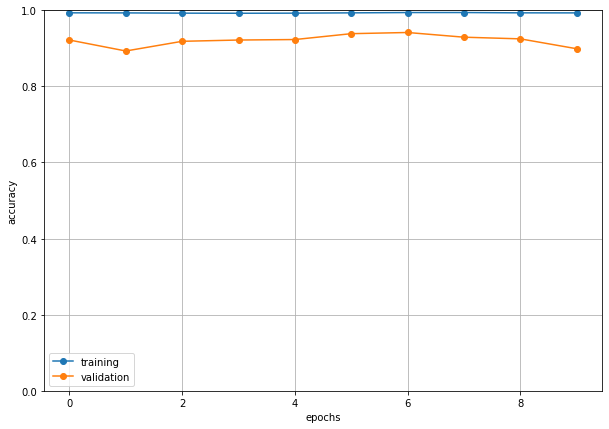

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.epoch,history.history['accuracy'],'-o',label='training')
plt.plot(history.epoch,history.history['val_accuracy'],'-o',label='validation')

plt.yticks(np.arange(0.0, 1.1, step=0.2))

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

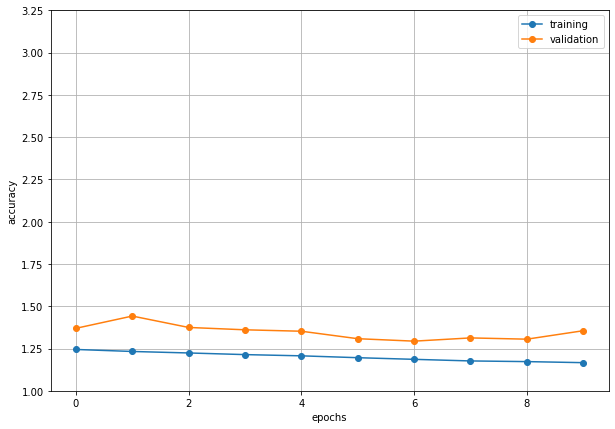

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.epoch,history.history['loss'],'-o',label='training')
plt.plot(history.epoch,history.history['val_loss'],'-o',label='validation')

plt.yticks(np.arange(1.0, 3.5, step=0.25))

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

#eval

In [ ]:
# change the label_smoothing value (0.1 for example) and compare results  
def Loss_compute(y_true, y_pred, label_smoothing=0.2):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing = label_smoothing)
    return loss

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/MI Project/test17_wide_ResNet50_LSTM_30Epochs.h5', custom_objects={ 'Loss_compute': Loss_compute})

In [ ]:
val_gen = ImageDataGenerator(rescale=1.0/255.0)

val_gene = val_gen.flow_from_directory(
    '/content/content/v',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BatchSize,
    shuffle=False, # False for eval
    interpolation="nearest")

Found 3898 images belonging to 10 classes.


In [ ]:
p = model.predict(val_gene, verbose=1)
pr = np.argmax(p, axis=1)

In [ ]:
from sklearn.metrics import recall_score , f1_score ,precision_score
print(' recall is : ' , recall_score (val_gene.labels, pr, average='macro'))
print(' precision is : ' , precision_score(val_gene.labels, pr, average='macro'))
print(' f1 Score is : ' , f1_score(val_gene.labels, pr, average='macro'))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_gene.labels, pr))

In [ ]:
from sklearn.metrics import confusion_matrix
cms = confusion_matrix(val_gene.classes, pr)
cms

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cms
df_cm = pd.DataFrame(array, index =  ['safe driving' , 'texting - right' , 'talking on the pohne - right' , 'texting - left' , 'talking in the phone - left' , 'operating the radio' , 'drinking' , 'reaching behind' ,'hair and makeup' ,'talking to passenger'],
                  columns = ['safe driving' , 'texting - right' , 'talking on the pohne - right' , 'texting - left' , 'talking in the phone - left' , 'operating the radio' , 'drinking' , 'reaching behind' ,'hair and makeup' ,'talking to passenger'])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, fmt=".1f")

In [ ]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

In [ ]:
path = '/content/drive/My Drive/test_files/Copy of img_94134.jpg'
from keras.preprocessing import image
show = plt.imread(path)
test_image1 = image.load_img(path, target_size=(224, 224), color_mode='rgb')
test_image = image.img_to_array(test_image1)
test_image = np.expand_dims(test_image, axis=0)

fig, (ax1, ax2) = plt.subplots(figsize=(7,11), ncols=1, nrows=2) 
y_preds = model.predict(test_image/255)
ax1.set_title(activity_map['c' + str(np.argmax(y_preds))])
ax1.imshow(show)
ax1.axis('off')

n = 5
y_predss = np.sort(y_preds)[:,-n:][0]
y_preds = np.argsort(y_preds)[:,-n:][0]
y_pos = np.arange(len(y_preds))

ax2.barh(y_pos, y_predss)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([activity_map['c' + str(x)] for x in list(y_preds)])
ax2.invert_yaxis()

In [ ]:
path = '/content/drive/MyDrive/test_files/Copy of img_68689.jpg'
from keras.preprocessing import image
show = plt.imread(path)
test_image1 = image.load_img(path, target_size=(224, 224), color_mode='rgb')
test_image = image.img_to_array(test_image1)
test_image = np.expand_dims(test_image, axis=0)

fig, (ax1, ax2) = plt.subplots(figsize=(7,11), ncols=1, nrows=2) 
y_preds = model.predict(test_image/255)
ax1.set_title(activity_map['c' + str(np.argmax(y_preds))])
ax1.imshow(show)
ax1.axis('off')

n = 3
y_predss = np.sort(y_preds)[:,-n:][0]
y_preds = np.argsort(y_preds)[:,-n:][0]
y_pos = np.arange(len(y_preds))

ax2.barh(y_pos, y_predss)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([activity_map['c' + str(x)] for x in list(y_preds)])
ax2.invert_yaxis()

In [ ]:
dir = '/content/content/v2_cam1_cam2_ split_by_driver/Camera 1/test/'
cn = 'c7'
shola = os.listdir(f'{dir}{cn}/')[:30]
shola

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
imgr = []
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 30))
for i in range(n):
    ax = axes.flat[i]
    path = f'{dir}{cn}/' + str(shola[i])
    pla1 = image.load_img(path, target_size=(224, 224), color_mode='rgb')
    pla = image.img_to_array(pla1)
    pla = np.expand_dims(pla, axis=0)
    ax.imshow(pla1)
    ax.set_title(activity_map['c' + str(np.argmax(model.predict(pla/255)))])
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
model_name = 'test17_wide_ResNet50_300Epochs_last_last.h5'
save_dir = '/content/drive/My Drive/Naser_DDS'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)